# Abstract
This tutorial aims to be a simple starter kit for people wanting to experiment continual semantic segmentation. To simplify experiments and developments of methods, we propose Continual-Extended-Mnist, a new toy dataset for continual segmentation that reflects the same scenarios explored in recent papers. We explain two of the important challenges, namely catastrophic forgetting coupled with background shift, and show how a naïve baseline systematically fails even on our black-and-white low-resolution images. Then, we introduce a few tricks popularized by the papers “Knowledge Distillation for Incremental Learning in Semantic Segmentation” and “Modeling the Background for Incremental Learning in Semantic Segmentation” (MiB).

# Introduction
If we look at papers on continual learning for classification, most of them experiment on simple datasets such as MNIST, CIFAR10 or Mini-Imagenet. These are small-scale datasets of tiny images which are used to experiment on a relatively simple task: classify object-centered images. On the other hand, the datasets employed to explore the more complex task of continual semantic segmentation are generally Pascal-VOC, ADE20K or COCO: ~10K to 20K high-resolution images with many objects in each image, which requires several hours of training on GPUs, if not days.

While toy datasets are sometimes blamed to be unrealistic as they are much more simple than real-life scenarios, they serve a non negligeable purpose. **They accelerate the research cycle and development of models** as they remove unnecessary complicated variables while keeping most of the essentials. It allows to do many runs of experiments with different models in a fraction of the time to see if it addresses the problems we aim to solve, i.e. in our case catastrophic forgetting especially. If a technique cannot reduce catastrophic forgetting on 60x60 black-and-white images, obviously there is no reason to think that it will solve it on real images of complex scenes.


# Continual Extended Mnist

We owe the generation of the raw data to this [repository](https://github.com/LukeTonin/simple-deep-learning) made by Luke Tonin. He also made an excellent tutorial for [simple semantic segmentation ](https://awaywithideas.com/mnist-extended-a-dataset-for-semantic-segmentation-and-object-detection/) that was an inspiration for ours. We started from this dataset and adapted it to a class-incremental learning scenario, i.e. classes are seen sequentially in successive tasks. In the first task, the model has to learn to segment 0's and 1's, then in the next task it must learn 2's and 3's, then 4's and 5's, and so on. 

Let's first take a look at the dataset.

In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
1

1

In [12]:
import os
import sys
#os.chdir("/content/gdrive/MyDrive/Colab Notebooks/mnist_continual_seg")
sys.path.append("/root/mnist_continual_seg/simple-deep-learning/simple_deep_learning")
import matplotlib.pyplot as plt
%matplotlib inline  
from scenarios import ContinualMnist

_tasks = {0: [0,1], 1: [2,3], 2: [4,5], 3: [6,7], 4: [8,9]}
continual_mnist = ContinualMnist(n_train=1000, n_test=500, batch_size=16, tasks=_tasks, overlap=False)

[0 0 0 ... 0 0 0]
[0 1 0 ... 1 1 0]


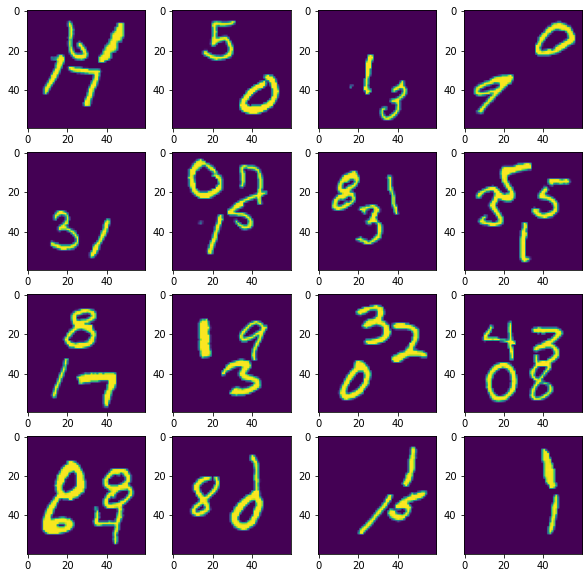

In [8]:
plt.figure(figsize=(10,10))
for i in range(4):
  for j in range(4):
    plt.subplot(4, 4, i*4+j+1)
    plt.imshow(continual_mnist.train_data[i*4+j][0][0])
plt.show()

As we can see, there are several classes on every image, similar to complex segmentation datasets that most often contain many objects e.g. chairs, tables, persons, etc.

Also, note that in a given task, the model receives images that necessarily contain at least one object of current classes, but theyt can also contain past and future classes. For instance, in the first task, the model could be fed with these (image, mask) pairs:

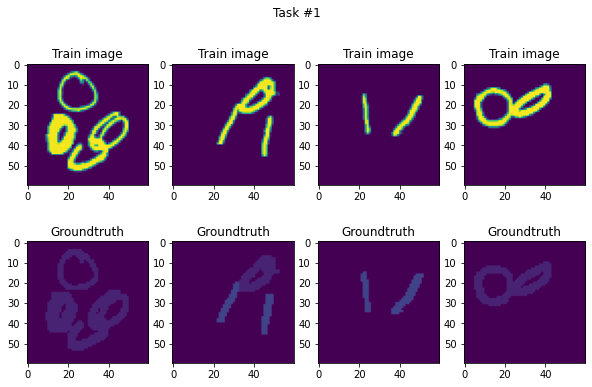

In [13]:
fig = plt.figure(figsize=(10,6))
fig.suptitle('Task #1')
for i in range(4):
  plt.subplot(2, 4, i+1)
  plt.title("Train image")
  plt.imshow(continual_mnist.train_data[i][0][0])
  plt.subplot(2, 4, i+5)
  plt.title("Groundtruth")
  plt.imshow(continual_mnist.train_data[i][1], vmin=0, vmax=10)
plt.show()

Now if we switch to the next step:

In [14]:
continual_mnist.next_task()

[3 3 3 ... 2 2 3]
[2 3 3 ... 2 3 3]


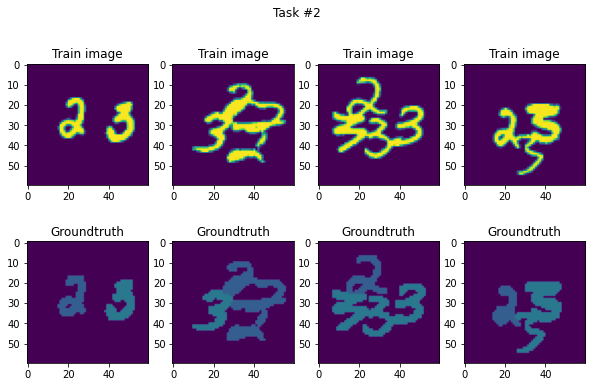

In [15]:
fig = plt.figure(figsize=(10,6))
fig.suptitle('Task #2')
for i in range(4):
  plt.subplot(2, 4, i+1)
  plt.title("Train image")
  plt.imshow(continual_mnist.train_data[i][0][0])
  plt.subplot(2, 4, i+5)
  plt.title("Groundtruth")
  plt.imshow(continual_mnist.train_data[i][1], vmin=0, vmax=10)
plt.show()

We see that 2's and 3's are annotated with their corresponding semantic masks, but previous and future classes are annotated as 'background'. This is the exact scenario tackled in recent papers on continual semantic segmentation and introduced by [MiB](https://openaccess.thecvf.com/content_CVPR_2020/papers/Cermelli_Modeling_the_Background_for_Incremental_Learning_in_Semantic_Segmentation_CVPR_2020_paper.pdf).

This has been termed the problem of "background shift". It is a significant challenge because if nothing is done to address it, forward AND backward transfer will be strongly impacted.

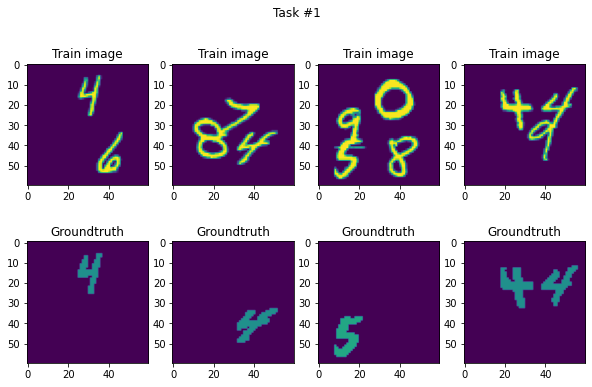

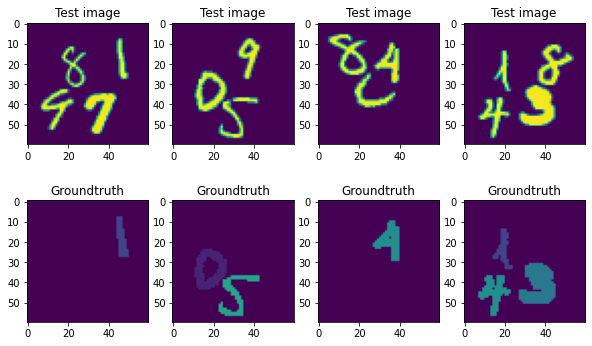

In [11]:
fig = plt.figure(figsize=(10,6))
fig.suptitle('Task #1')
for i in range(4):
  plt.subplot(2, 4, i+1)
  plt.title("Train image")
  plt.imshow(continual_mnist.train_data[i][0][0])
  plt.subplot(2, 4, i+5)
  plt.title("Groundtruth")
  plt.imshow(continual_mnist.train_data[i][1], vmin=0, vmax=10)
plt.show()

plt.figure(figsize=(10,6))
for i in range(4):
  plt.subplot(2, 4, i+1)
  plt.title("Test image")
  plt.imshow(continual_mnist.test_data[i][0][0])
  plt.subplot(2, 4, i+5)
  plt.title("Groundtruth")
  plt.imshow(continual_mnist.test_data[i][1], vmin=0, vmax=10)
plt.show()
  